In [1]:
#John Gizis
#Plot parallax observations for a given LSST simulation. adopted from Peter Yoachim's code at https://github.com/yoachim/LSST-BD-Cadence/blob/main/Pass_example.ipynb


In [2]:
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName==self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName!=self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (key is not 'bins') & (key is not 'binCol'):
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did yo

In [3]:
dbFile = '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db' 
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='illustrate'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
bundleList = []
#sql = 'filter="z" or filter="y"'
sql = 'visitExposureTime > 15.'
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', 'ra_pi_amp',
                                  'dec_pi_amp', 'seeingFwhmGeom','observationStartMJD'
                                 ])
slicer = slicers.UserPointsSlicer(ra=0, dec=-20.)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))


In [5]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with constraint visitExposureTime > 15. for columns ['observationStartMJD', 'fieldDec', 'filter', 'fiveSigmaDepth', 'fieldRA', 'seeingFwhmGeom']
Found 2045493 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_Pass_filter_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_observationStartMJD_visitExposureTime_gt_15_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [6]:
bundleList[0].metricValues[0].dtype
dataSlice = bundleList[0].metricValues[0]

In [7]:
dataSlice.dtype


dtype([('observationStartMJD', '<f8'), ('fieldDec', '<f8'), ('filter', '<U256'), ('fiveSigmaDepth', '<f8'), ('fieldRA', '<f8'), ('seeingFwhmGeom', '<f8'), ('ra_pi_amp', '<f8'), ('dec_pi_amp', '<f8')])

In [8]:
# Here's the parallax amplitude. I'll just assume a 1" parallax star, but could multiply by any factor.
parallax_amplitude = (dataSlice['ra_pi_amp']**2 + dataSlice['dec_pi_amp']**2)**0.5
star_mag = 20.  # Just assume a flat SED. This is used in the estimate of the uncertainty.
snr = parallax_amplitude*0
atm_err = 0.01

for filt in np.unique(dataSlice['filter']):
    good = np.where(dataSlice['filter'] == filt)
    snr[good] = mafUtils.m52snr(star_mag, dataSlice['fiveSigmaDepth'][good])
position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice['seeingFwhmGeom'],
                                                            snr)**2+atm_err**2)

Text(0, 0.5, 'Parallax Amplitude (arcsec)')

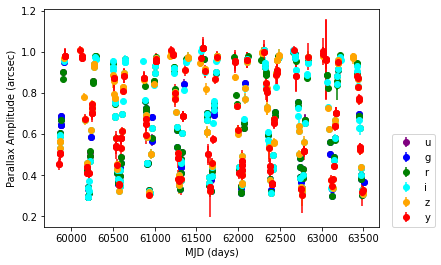

In [9]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filt in 'ugrizy':
    good = np.where(dataSlice['filter'] == filt)
    plt.errorbar(dataSlice['observationStartMJD'][good], parallax_amplitude[good], yerr=position_errors[good],
                color=f2c[filt], fmt='o', label=filt)
plt.legend(loc=(1.04,0))
plt.xlabel('MJD (days)')
plt.ylabel('Parallax Amplitude (arcsec)')

In [26]:
izy = np.where((dataSlice['filter'] == 'z')|(dataSlice['filter'] == 'y'))
iz = np.where(dataSlice['filter'] == 'z')
iy = np.where(dataSlice['filter'] == 'y')
            

Text(0, 0.5, 'RA Parallax Factor')

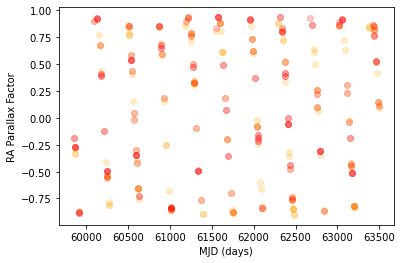

In [32]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   


In [21]:
days_since_start = dataSlice['observationStartMJD'] - np.min(dataSlice['observationStartMJD'])
years_since_start = days_since_start / 365.25636        #am I using right length of year? 
phase_years = years_since_start % 1

[8.83909345e-01 8.83954332e-01 7.89956091e-01 8.68793145e-01
 1.46622458e-01 8.05677840e-01 8.05632948e-01 7.90003724e-01
 9.82903151e-01 8.03263476e-01 9.82945968e-01 9.65871312e-01
 8.51036409e-01 9.47947103e-01 8.53105497e-01 1.82163639e-01
 1.20652548e-01 6.63088325e-01 9.65826344e-01 9.52822527e-01
 6.63017246e-01 9.10758300e-02 8.97153478e-01 9.52863184e-01
 9.43516332e-01 1.10678224e-01 6.43726063e-01 9.68821412e-01
 9.68776175e-01 1.20699458e-01 1.10637350e-01 8.97110456e-01
 2.18701423e-02 7.72828926e-01 9.43563813e-01 8.53150981e-01
 7.72786788e-01 6.43729743e-01 5.18250167e-02 1.45601977e-02
 9.20617204e-01 4.51674222e-02 9.20662525e-01 1.45148470e-02
 9.98583239e-01 9.43468819e-01 5.17840110e-02 1.35790860e-01
 1.48779046e-01 5.17472847e-02 5.17035951e-02 8.46060275e-01
 9.78060035e-01 9.70436936e-01 1.97131429e-01 1.48820104e-01
 9.78015630e-01 9.70554641e-01 9.70479844e-01 8.45958861e-01
 8.44223184e-01 7.74663307e-01 9.98541138e-01 1.90075198e-02
 9.70512360e-01 3.981980

Text(0, 0.5, 'Parallax Factor')

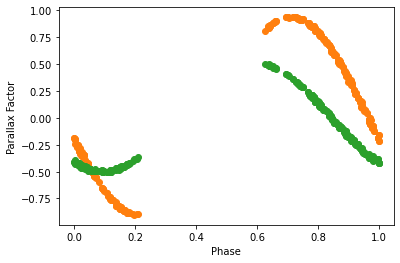

In [24]:
plt.plot(phase_years[izy],dataSlice['ra_pi_amp'][izy],'o',color='C1')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor')   



In [25]:
np.size(dataSlice['ra_pi_amp'][izy])

345

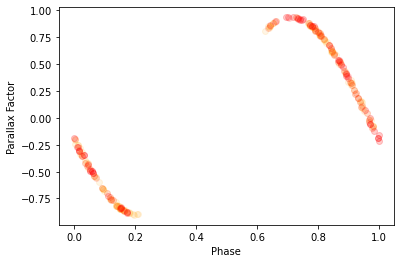

In [31]:
plt.plot(phase_years[iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.1)
plt.plot(phase_years[iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.1)
plt.xlabel('Phase')
plt.ylabel('Parallax Factor');

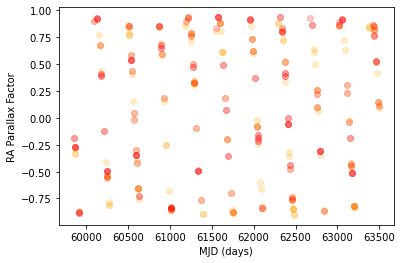

In [33]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   
plt.savefig('parallaxes_zy.png')
